In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import xgboost
pd.set_option("display.max_columns",None)

In [2]:
data=pd.read_csv("pima-data.csv")

In [3]:
data.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


In [4]:
data.shape

(768, 10)

# Imbalanced Data?

In [5]:
(len(data.loc[data["diabetes"]==True])/len(data))*100

34.89583333333333

In [6]:
(len(data.loc[data["diabetes"]==False])/len(data))*100

65.10416666666666

<AxesSubplot:>

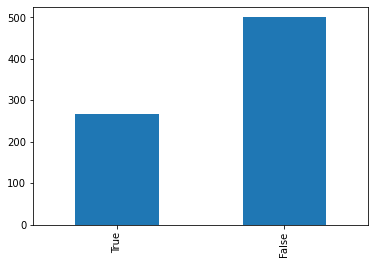

In [7]:
data["diabetes"].value_counts(dropna=False).sort_values().plot(kind="bar")

#### The data is imbalanced, So we use Ensemble models or Imblearn imbalanced models 

# Features with Null Data?

In [8]:
null=[i for i in data.columns if (data[i].isnull().sum())>0]

data[null].head()

""
0
1
2
3
4


#### No null values

# Categorical Features

In [9]:
cat_feat=[i for i in data.columns if data[i].dtypes =="O"]
data[cat_feat].head()

""
0
1
2
3
4


In [10]:
boolfeat=[i for i in data.columns if data[i].dtypes=="bool"]

data[boolfeat].head()

,diabetes
0,True
1,False
2,True
3,False
4,True


In [11]:
for i in boolfeat:
    data[i]=np.where(data[i]==True,1,0)

# Numerical Features

#### a. Discrete Numerical Features

In [12]:
disc_feat=[i for i in data.columns if len(data[i].unique())<25]

data[disc_feat].head()

,num_preg,diabetes
0,6,1
1,1,0
2,8,1
3,1,0
4,0,1


#### b. Continous Features

In [13]:
cont_feat=[i for i in data.columns if i not in disc_feat]
data[cont_feat].head()

,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
0,148,72,35,0,33.6,0.627,50,1.3790
1,85,66,29,0,26.6,0.351,31,1.1426
2,183,64,0,0,23.3,0.672,32,0.0000
3,89,66,23,94,28.1,0.167,21,0.9062
4,137,40,35,168,43.1,2.288,33,1.3790


In [14]:
for i in cont_feat:
    data.loc[data[i]==0,i]=data[i].median()

In [16]:
data[cont_feat].head()

,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
0,148,72,35,30.5,33.6,0.627,50,1.3790
1,85,66,29,30.5,26.6,0.351,31,1.1426
2,183,64,23,30.5,23.3,0.672,32,0.9062
3,89,66,23,94.0,28.1,0.167,21,0.9062
4,137,40,35,168.0,43.1,2.288,33,1.3790


In [21]:
x=data.drop(columns="diabetes")

y=data["diabetes"]

In [40]:
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split,StratifiedKFold

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from imblearn.combine import SMOTEENN,SMOTETomek

from sklearn.linear_model import LogisticRegression


In [41]:
adc=AdaBoostClassifier()
rfc=RandomForestClassifier()
xgc=xgboost.XGBClassifier()
bgc=BaggingClassifier()
log=LogisticRegression()

In [22]:
trainx,testx,trainy,testy=train_test_split(x,y,test_size=0.25,random_state=5)

In [23]:
trainx.shape,testx.shape,trainy.shape,testy.shape

((576, 9), (192, 9), (576,), (192,))

In [28]:
from collections import Counter

In [31]:
Counter(trainy)

Counter({0: 368, 1: 208})

In [33]:
scorea1=cross_val_score(adc,trainx,trainy,cv=10)

scorea1.mean()

0.7344827586206897

In [35]:
scoreb1=cross_val_score(bgc,trainx,trainy,cv=10)

scoreb1.mean()

0.7345130066545675

In [37]:
scorer1=cross_val_score(rfc,trainx,trainy,cv=10)

scorer1.mean()

0.753448275862069

In [39]:
scorex1=cross_val_score(xgc,trainx,trainy,cv=10,n_jobs=-1)

scorex1.mean()

0.7361161524500908

In [42]:
scorel1=cross_val_score(log,trainx,trainy,cv=10,n_jobs=-1)

scorel1.mean()

0.746551724137931

In [43]:
from sklearn.svm import SVC
svc=SVC()

In [44]:
scores1=cross_val_score(svc,trainx,trainy,cv=10,n_jobs=-1)

scores1.mean()

0.7448578342407743

In [45]:
n_estimators = [int(i) for i in np.linspace(100,2000,50)]
criterion = ["gini", "entropy"]
max_depth = [i for i in np.linspace(100,1000,10)]
min_samples_split = [i for i in np.arange(2,11)]
min_samples_leaf = [i for i in np.arange(0,11)]
max_features = ["auto", "sqrt", "log2"]

In [46]:
search={"n_estimators":n_estimators,
        "criterion" : criterion,
        "max_depth" : max_depth,
        "min_samples_split" : min_samples_split,
        "min_samples_leaf" : min_samples_leaf,
        "max_features" : max_features}

In [47]:
bestrf=RandomizedSearchCV(estimator=rfc,param_distributions=search,n_iter=10,cv=10,n_jobs=-1,verbose=2,random_state=100)

In [48]:
bestrf.fit(trainx,trainy)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [100.0, 200.0, 300.0,
                                                      400.0, 500.0, 600.0,
                                                      700.0, 800.0, 900.0,
                                                      1000.0],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [0, 1, 2, 3, 4, 5,
                                                             6, 7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 138, 177, 216,
                                       

In [49]:
bestrf.best_estimator_

RandomForestClassifier(max_depth=400.0, max_features='log2', min_samples_leaf=3,
                       min_samples_split=7, n_estimators=1573)

In [50]:
y1=bestrf.predict(testx)

print(accuracy_score(testy,y1)*100)

print(classification_report(testy,y1))

print(confusion_matrix(testy,y1))

76.5625
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       132
           1       0.62      0.67      0.64        60

    accuracy                           0.77       192
   macro avg       0.73      0.74      0.73       192
weighted avg       0.77      0.77      0.77       192

[[107  25]
 [ 20  40]]


In [52]:
searchlog={"penalty":['l1', 'l2', 'elasticnet', 'none'],
           "tol":[float(i) for i in np.linspace(0.0001,0.01,100)],
           "C":[float(i) for i in np.linspace(1,10,10)],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "max_iter":[int(i) for i in np.linspace(10,2000,100)],
           "multi_class":['auto', 'ovr', 'multinomial'],
          "intercept_scaling":[float(i) for i in np.linspace(1,100,100)]}

In [53]:
bestlog=RandomizedSearchCV(estimator=log,param_distributions=searchlog,n_iter=10,cv=10,n_jobs=-1,verbose=2,random_state=100)

In [54]:
bestlog.fit(trainx,trainy)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                                              8.0, 9.0, 10.0],
                                        'intercept_scaling': [1.0, 2.0, 3.0,
                                                              4.0, 5.0, 6.0,
                                                              7.0, 8.0, 9.0,
                                                              10.0, 11.0, 12.0,
                                                              13.0, 14.0, 15.0,
                                                              16.0, 17.0, 18.0,
                                                              19.0, 20.0, 21.0,
                                                              22.0, 23.0, 24.0,
                                                              25.0, 26.0, 27.0,
                                                              28.0, 29.0, 30

In [55]:
y2=bestlog.predict(testx)

print(accuracy_score(testy,y2)*100)

print(classification_report(testy,y2))

print(confusion_matrix(testy,y2))

79.6875
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       132
           1       0.68      0.67      0.67        60

    accuracy                           0.80       192
   macro avg       0.76      0.76      0.76       192
weighted avg       0.80      0.80      0.80       192

[[113  19]
 [ 20  40]]


In [163]:
RFR=RandomForestClassifier(n_estimators=800)

In [164]:
RFR.fit(trainx,trainy)

RandomForestClassifier(n_estimators=800)

In [165]:
y10=RFR.predict(testx)

print(accuracy_score(testy,y10)*100)

print(classification_report(testy,y10))

print(confusion_matrix(testy,y10))

77.60416666666666
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       132
           1       0.62      0.72      0.67        60

    accuracy                           0.78       192
   macro avg       0.74      0.76      0.75       192
weighted avg       0.79      0.78      0.78       192

[[106  26]
 [ 17  43]]


In [56]:
searchxg={"n_estimators":[int(i) for i in np.linspace(100,2000,25)],
       "learning_rate":[float(i) for i in np.linspace(0,1,20)],
       "max_depth":[int(i) for i in np.arange(1,11)],
       "min_child_weight":[float(i) for i in np.linspace(0,2,20)],
       "gamma":[float(i) for i in np.linspace(0,2,20)],
         "base_score":[float(i) for i in np.linspace(0,1,20)],
        "importance_type":["gain", "weight", "cover", "total_gain", "total_cover"],
        "num_parallel_tree":[int(i) for i in np.arange(1,11)]}

In [57]:
bestxg=RandomizedSearchCV(estimator=xgc,param_distributions=searchxg,cv=10,n_iter=1,random_state=100)

In [58]:
bestxg.fit(trainx,trainy)

C:\Users\Daniel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                                             1.0526315789473684,
                                                             1.1578947368421053,
                   

In [59]:
y3=bestxg.predict(testx)

print(accuracy_score(testy,y3)*100)

print(classification_report(testy,y3))

print(confusion_matrix(testy,y3))

71.875
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       132
           1       0.54      0.63      0.58        60

    accuracy                           0.72       192
   macro avg       0.68      0.70      0.69       192
weighted avg       0.73      0.72      0.72       192

[[100  32]
 [ 22  38]]


In [60]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier()

In [74]:
score=[]
for i in np.arange(1,31):
    val=cross_val_score(KNeighborsClassifier(n_neighbors=i),trainx,trainy,cv=10)
    score.append(val.mean())


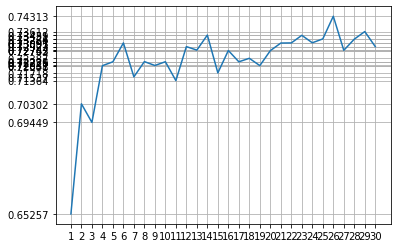

In [76]:

plt.grid()    
plt.plot(np.arange(1,31),score)

plt.xticks(np.arange(1,31))
plt.yticks(score)
plt.show()



In [78]:
knmodel=KNeighborsClassifier(n_neighbors=26).fit(trainx,trainy)

In [79]:
y4=knmodel.predict(testx)

print(accuracy_score(testy,y4)*100)

print(classification_report(testy,y4))

print(confusion_matrix(testy,y4))

76.04166666666666
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       132
           1       0.63      0.57      0.60        60

    accuracy                           0.76       192
   macro avg       0.72      0.71      0.71       192
weighted avg       0.75      0.76      0.76       192

[[112  20]
 [ 26  34]]


In [114]:
searchkn={"n_neighbors":[2,4,5,6,7,8,9,10,12,15,19,23,25,27,29],
         "weights":['uniform', 'distance'],
         "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute'],
         "leaf_size":[int(i) for i in np.linspace(10,105,20)],
         "p":[int(i) for i in np.arange(1,10)]}

In [115]:
bestkn=RandomizedSearchCV(estimator=kn,param_distributions=searchkn,cv=10,n_iter=1,random_state=100)

In [116]:
bestkn.fit(trainx,trainy)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, 105],
                                        'n_neighbors': [2, 4, 5, 6, 7, 8, 9, 10,
                                                        12, 15, 19, 23, 25, 27,
                                                        29],
                                        'p': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                                        'weights': ['uniform', 'distance']},
                   random_state=100)

In [117]:
bestkn.best_params_

{'weights': 'uniform',
 'p': 4,
 'n_neighbors': 27,
 'leaf_size': 10,
 'algorithm': 'ball_tree'}

In [118]:
y5=bestkn.predict(testx)

print(accuracy_score(testy,y5)*100)

print(classification_report(testy,y5))

print(confusion_matrix(testy,y5))

71.875
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       132
           1       0.55      0.55      0.55        60

    accuracy                           0.72       192
   macro avg       0.67      0.67      0.67       192
weighted avg       0.72      0.72      0.72       192

[[105  27]
 [ 27  33]]


In [119]:
smotmek=SMOTETomek()

In [125]:
trainxsk,trainysk=smotmek.fit_sample(trainx,trainy)

testxsk,testysk=smotmek.fit_sample(testx,testy)

In [121]:
Counter(trainysk)

Counter({0: 354, 1: 354})

In [134]:
bestlogmodel=bestlog.best_estimator_

In [135]:
bestlogmodel.fit(trainxsk,trainysk)

LogisticRegression(C=4.0, intercept_scaling=11.0, max_iter=1417,
                   multi_class='ovr', solver='liblinear', tol=0.0093)

In [136]:
y6=bestlogmodel.predict(testxsk)

print(accuracy_score(testysk,y6)*100)

print(classification_report(testysk,y6))

print(confusion_matrix(testysk,y6))

75.79365079365078
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       126
           1       0.75      0.78      0.76       126

    accuracy                           0.76       252
   macro avg       0.76      0.76      0.76       252
weighted avg       0.76      0.76      0.76       252

[[93 33]
 [28 98]]


In [127]:
bestrfmodel=bestrf.best_estimator_

In [128]:
bestrfmodel.fit(trainxsk,trainysk)

RandomForestClassifier(max_depth=400.0, max_features='log2', min_samples_leaf=3,
                       min_samples_split=7, n_estimators=1573)

In [129]:
y7=bestrfmodel.predict(testxsk)

print(accuracy_score(testysk,y7)*100)

print(classification_report(testysk,y7))

print(confusion_matrix(testysk,y7))

82.14285714285714
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       126
           1       0.80      0.85      0.83       126

    accuracy                           0.82       252
   macro avg       0.82      0.82      0.82       252
weighted avg       0.82      0.82      0.82       252

[[100  26]
 [ 19 107]]


In [139]:
sn=SMOTEENN()


In [145]:
trainxn,trainyn=sn.fit_sample(trainx,trainy)

testxn,testyn=sn.fit_sample(testx,testy)

In [142]:
Counter(trainyn)

Counter({0: 159, 1: 209})

In [143]:
bestrfcmodel=bestrf.best_estimator_

In [144]:
bestrfcmodel.fit(trainxn,trainyn)

RandomForestClassifier(max_depth=400.0, max_features='log2', min_samples_leaf=3,
                       min_samples_split=7, n_estimators=1573)

In [146]:
y8=bestrfcmodel.predict(testxn)

print(accuracy_score(testyn,y8)*100)

print(classification_report(testyn,y8))

print(confusion_matrix(testyn,y8))

88.88888888888889
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        74
           1       0.89      0.91      0.90        88

    accuracy                           0.89       162
   macro avg       0.89      0.89      0.89       162
weighted avg       0.89      0.89      0.89       162

[[64 10]
 [ 8 80]]


In [147]:
bestlgmodel=bestlog.best_estimator_

In [148]:
bestlgmodel.fit(trainxn,trainyn)

LogisticRegression(C=4.0, intercept_scaling=11.0, max_iter=1417,
                   multi_class='ovr', solver='liblinear', tol=0.0093)

In [150]:
y9=bestlgmodel.predict(testxn)

print(accuracy_score(testyn,y9)*100)

print(classification_report(testyn,y9))

print(confusion_matrix(testyn,y9))

82.71604938271605
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        74
           1       0.91      0.76      0.83        88

    accuracy                           0.83       162
   macro avg       0.83      0.83      0.83       162
weighted avg       0.84      0.83      0.83       162

[[67  7]
 [21 67]]


In [158]:
a=[100,400,800,1200,1600,2000]

In [159]:
score=[]
for i in a:
    RF=RandomForestClassifier(n_estimators=i)
    val=cross_val_score(RF,trainx,trainy,cv=5,n_jobs=-1)
    score.append(val.mean())

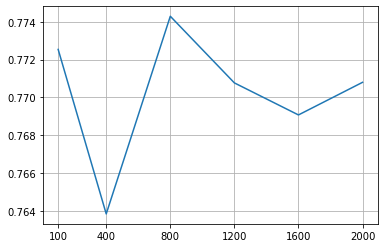

In [160]:
plt.grid()
plt.plot(a,score)
plt.xticks(a)

plt.show()

In [ ]:
n_estimators = [int(i) for i in np.linspace(100,2000,50)]
criterion = ["gini", "entropy"]
max_depth = [i for i in np.linspace(100,1000,10)]
min_samples_split = [i for i in np.arange(2,11)]
min_samples_leaf = [i for i in np.arange(0,11)]
max_features = ["auto", "sqrt", "log2"]

In [173]:
b=[50,100,150,200,250,300,450,550,700,850,950,1000]

In [186]:
score=[]
for i in np.arange(10,1000,20):
    RF=RandomForestClassifier(max_depth=i)
    val=cross_val_score(RF,trainx,trainy,cv=5,n_jobs=-1)
    score.append(val.mean())

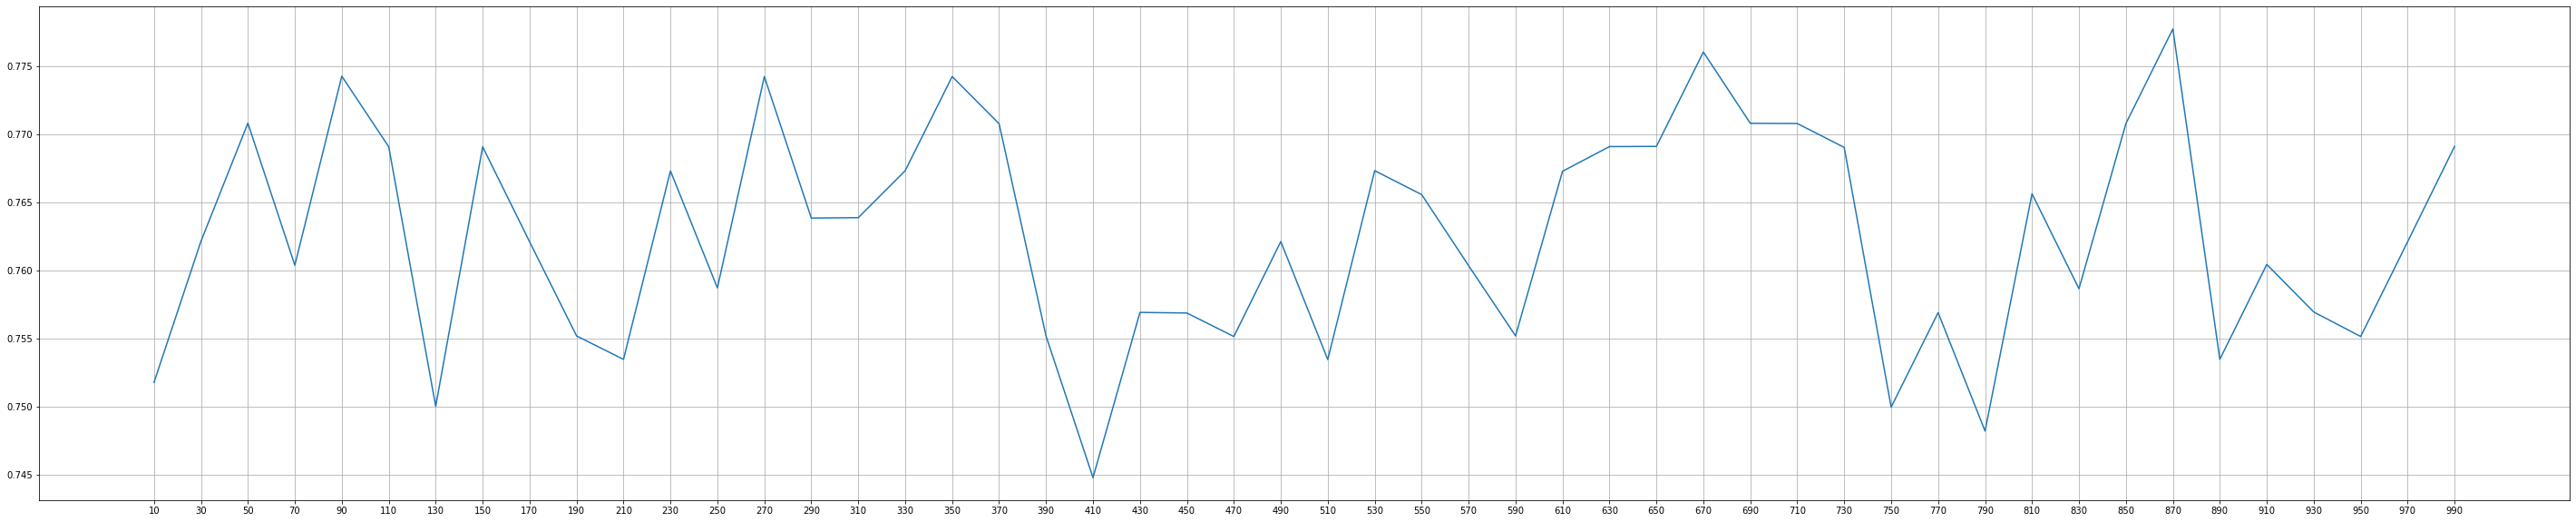

In [189]:
plt.figure(figsize=(50,10))

plt.grid()
plt.plot(np.arange(10,1000,20),score)
plt.xticks(np.arange(10,1000,20))

plt.show()

In [182]:
np.arange(10,100,10)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])